In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import h5py
import numpy as np
import json
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import Image, display, clear_output
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
sns.set_style('whitegrid')

In [ ]:
from keras import optimizers
from keras import applications
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense, Input
from keras.regularizers import l2, l1
#from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, History
from keras import backend as K
#from keras.utils.data_utils import get_file
from tensorflow.keras.utils import load_img

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array

In [ ]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

    axes = axes.flatten()

    axes[0].plot(range(stop), hist['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')

    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')

    plt.tight_layout();

    print("Best Model:")
    print_best_model_results(hist)

In [ ]:
def plot_acc_metrics(hist1, hist2, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,6))

    axes = axes.flatten()

    axes[0].plot(range(stop), hist1['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist1['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')

    axes[1].plot(range(stop), hist2['accuracy'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist2['val_accuracy'], label='Validation', color='#03507E')
    axes[1].set_title('Fine-tuning')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='lower right')

    plt.tight_layout();

In [ ]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_accuracy'])
    print('epoch:', best_epoch+1, \
    ', val_accuracy:', model_hist['val_accuracy'][best_epoch], \
    ', val_loss:', model_hist['val_loss'][best_epoch])

In [ ]:
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1./255)

    model = VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(train_data_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_train = model.predict(generator, nb_train_samples // batch_size)
    np.save(location+'/bottleneck_features_train.npy', bottleneck_features_train)

    generator = datagen.flow_from_directory(validation_data_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_validation = model.predict(generator, nb_validation_samples // batch_size)
    np.save(location+'/bottleneck_features_validation.npy', bottleneck_features_validation)

In [ ]:
def train_top_model():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto')

    fit = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size,validation_data=(validation_data,validation_labels), callbacks=[checkpoint])

    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
def finetune_binary_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
    print("Model loaded.")

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))

    top_model.load_weights(top_model_weights_path)

    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

    for layer in model.layers[:25]:
        layer.trainable = False

    model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])

    train_datagen = ImageDataGenerator(rescale = 1./255, zoom_range=0.2, shear_range=0.2, horizontal_flip=True)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='binary')

    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

    fit = model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])

    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
def evaluate_binary_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(directory, target_size=(img_height,img_width), batch_size=batch_size, class_mode='binary', shuffle=False)

    predictions = model.predict(generator, len(labels))

    pred_labels = [0 if i<0.5 else 1 for i in predictions]

    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

In [ ]:
#Defining Input

location = '/content/drive/MyDrive/DS_Project/Final_Dataset/augumentation_data_1/data_1'
top_model_weights_path = location+'/top_model_weights.h5'
fine_tuned_model_path = location+'/ft_model.h5'

train_data_dir = location+'/train'
validation_data_dir = location+'/test'
train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = 3680
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = 920

img_width, img_height = 256,256
epochs = 1
#epochs = 1
batch_size = 16

In [ ]:
#save_bottleneck_features()

58889256/58889256 [==============================] - 1s 0us/step
Found 3680 images belonging to 2 classes.
230/230 [==============================] - 2910s 13s/step
Found 920 images belonging to 2 classes.
58/58 [==============================] - 719s 12s/step


In [ ]:
d2_model1, d2_history1 = train_top_model()

230/230 [==============================] - ETA: 0s - loss: 0.8591 - accuracy: 0.8372
Epoch 1: val_accuracy improved from -inf to 0.83261, saving model to /content/drive/MyDrive/DS_Project/Final_Dataset/augumentation_data_1/data_1/top_model_weights.h5
230/230 [==============================] - 20s 86ms/step - loss: 0.8591 - accuracy: 0.8372 - val_loss: 0.5223 - val_accuracy: 0.8326


In [ ]:
#Fine Tuning
ft_model, ft_history = finetune_binary_model()

Model loaded.


Found 3680 images belonging to 2 classes.
Found 920 images belonging to 2 classes.


<ipython-input-10-b1f687c4d16b>:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit = model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])


230/230 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.7842 
Epoch 1: val_accuracy improved from -inf to 0.84430, saving model to /content/drive/MyDrive/DS_Project/Final_Dataset/augumentation_data_1/data_1/ft_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


230/230 [==============================] - 3632s 16s/step - loss: 0.7749 - accuracy: 0.7842 - val_loss: 0.5035 - val_accuracy: 0.8443


In [ ]:
ft_model = load_model(location+'/ft_model.h5')

In [ ]:
with open('/content/drive/MyDrive/DS_Project/Final_Dataset/augumentation_data_1/data_1/top_history.txt') as f:
    top_history = json.load(f)

In [ ]:
with open('/content/drive/MyDrive/DS_Project/Final_Dataset/augumentation_data_1/data_1/ft_history.txt') as f:
    ft_history = json.load(f)

In [ ]:
#plot_acc_metrics(top_history, ft_history)

In [ ]:
validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

In [ ]:
cm = evaluate_binary_model(ft_model, validation_data_dir, validation_labels)

Found 920 images belonging to 2 classes.
58/58 [==============================] - 748s 13s/step

              precision    recall  f1-score   support

           0       1.00      0.67      0.80       460
           1       0.75      1.00      0.86       460

    accuracy                           0.83       920
   macro avg       0.87      0.83      0.83       920
weighted avg       0.87      0.83      0.83       920




In [ ]:
heatmap_labels = ['Damaged', 'Whole']

<Axes: >

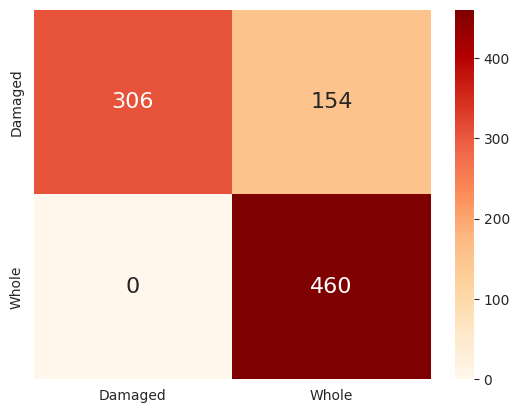

In [ ]:
sns.heatmap(cm, annot=True, annot_kws={"size":16}, fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels)

<Axes: >

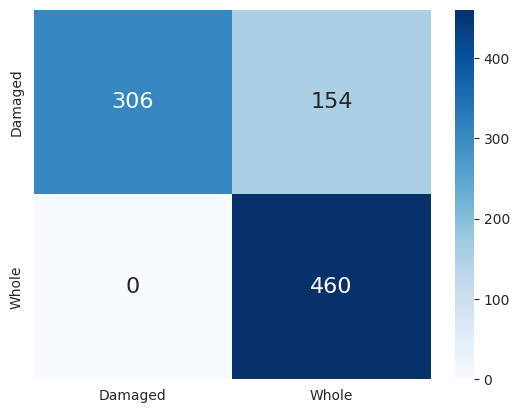

In [ ]:
sns.heatmap(cm, annot=True, annot_kws={"size":16}, fmt='g', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels)

In [ ]:
#pipe2

In [ ]:
def pipe2(image_path, model):
    urllib.request.urlretrieve(image_path, 'save.jpg')
    img = load_img('save.jpg', target_size=(256,256))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)/255
    pred = model.predict(x)
    print("Validating that damage exists....")
    print(pred)
    if(pred[0][0]<=0.5):
        print("Validation complete - proceed to location and severity determination")
    else:
        print ("Are you sure that your car is damaged? Please submit another picture of the damage.")
        print ("Hint: Try zooming in/out, using a different angle or different lighting")

In [ ]:
pipe2('https://i.ytimg.com/vi/4oV1klVPogY/maxresdefault.jpg', ft_model)

1/1 [==============================] - 1s 658ms/step
Validating that damage exists....
[[0.36997575]]
Validation complete - proceed to location and severity determination


In [ ]:
pipe2('data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBwgHBgkIBwgKCgkLDRYPDQwMDRsUFRAWIB0iIiAdHx8kKDQsJCYxJx8fLT0tMTU3Ojo6Iys/RD84QzQ5OjcBCgoKDQwNGg8PGjclHyU3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3N//AABEIAJQBDAMBIgACEQEDEQH/xAAcAAEAAQUBAQAAAAAAAAAAAAAABgEDBAUHAgj/xABCEAABAwMCAwQGBwUGBwAAAAABAAIDBAUREiEGMUETUWFxBxQiMoGRI0JSobHB0RUzQ2JyFjSCg5LwJEVTc3Sy0v/EABkBAQADAQEAAAAAAAAAAAAAAAABAgQDBf/EACMRAQEBAAICAgMAAwEAAAAAAAABAgMREiExQQQTUSJCgTL/2gAMAwEAAhEDEQA/AO4oiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgKhOF4klbG0ue4Na3mSdgolfuN6Sh+jpZIy7JGuTlnwHX7lMlqLZJ3UvLgOuyBwOMHnyXGaviapuMz9N8uQeN2sgcYAP6QGDPfuStbP6Tq+013aMgJlli0yZkzG8tPvBvRxzv5rr+jUnbnOaW9O85TIXCB6abtn+4wn4hX4fTRcc4kt0JP8AWo/Vf6ftn8dwBTK5BS+mOZ5AltLT/TIAtxR+lSnlIElqqW/0vaR+Kj9Wj9uXSEULbx/BLp7CgmcT0e7Ss6h40t9Q8Mqo5KJxIaPWMAZ8+Srcai03mpMitslbI1rmEOaeRByFcVVxERAREQEREBERAREQEREBERAREQEREBERAWJcK2K300lRUnSxncMk9wHisonC5xx7eBU3IWiJ+HatJwfdZpBe7zwQ0d26tjPlelda8Y0t6vt14gnc985o7fq+gghPtSD7T3fp5jHMxuq0+tyNibpigHZMA33+sc9STgE/y+K3NzqG0VIZWGJspBETXu9kAY3OPPZc+uF7qWVDmCoP+VUFw8lvxjEvyx262kEDnx1UIwc6xnyUb4phLJOW7HZz4Hb8gpBwbNJXyPlqHOIg1+/zHsj/AOlavVsnusYnt0L5o9GkvbjGoc101JrGsq5/xvtBRJkAggK6yQ9FuZbDcBHn9nSAkZ2AWC+1VcYzJBM3yiz+axeG59NHcvw8QzubtlbWgnlPtM5DnutP6vIz3mytPe6PH5rKo3PhzgB+fgkmlbmJXa7u5j2NdK4AqZ269OAa0vLm45O3C5IKgMlPtNbvyJ5LbU18jhDNcm4G5BV+65eFjsttrXQP7S1yxwPIy6nfn1eU+Q9w+I+IKlVqvUFeTC9pp6xoy6nkO+O9pGzh4hcHoOMKaJ0bXulGoZyW5H3KV2/iOguLY45J3AsOY3sdokhd0LT0Pwx5quuPy+HTPJcfPw7A05G69KCjjSe0U8YutK6sh5NrqTSA4fzsJ9l3lkHw5KU2O70l7oGVtBLrhdtnHIjmFx1x6z8xozvOvhsUVMoCqLqoqKqAiIgIiICIiAiIgIiICIiAqFVWNcKmOio56qbIjhjL3Y7gMoIJx5xtXWbiGG12+nZMxlOJ6kF2lxDiQADvj3T0PRWaK52+9ZrA6njlkB1MMgEoPLBXNLxdY77d7hdaslnrbSNAAIaA0NaN+mAM465+MdbUPbMHgg6SMbdRyXoceM5zKw8t8tO4MoLfWPkaWQzvhIDmtw4syM4/NYlx4XoauCoYaNjJZ2FvadmMg42PJcjqLnI6TXC6SEYGQHY9rrgjpnlnf8rkd8ucezK+qx/33FXszVJNT4rY09uuVpq5rXWXKjona2Ol1EvG7dySB0AbseefBT5vD1DPRwmN3rbdI+mY8gP257bDyXOLHc6OmrZZ7vbW3QSN3bJJgsdnOoE8z5qY0NVw5XkRW4Ot88hyI5W9mHOPIB7TpJ271bj1nF6ivJNX2y3cO0sBa1sfZguAzK4loyQN+4brMqODLzTkiGlopc8va2+ZWruQutEXR5lc3GlzHEkY8lrG8VXKhAbHUztA5APyPl+uVo5s8/zno4rm+q2FXY7vFVtpJ7JD20jC5gbk5A54I7lpquF1I90NRapIntbqLDGXbd5y04His+T0i3yVjWetRZHuulgGR5HbuWTP6RbzOWPdTW10rQG9oGPaSMg4O/I4XDy5/uSu8xn6rV03FjqJvZMjpOyGwbLDpx9+3yWQ3jcZ/cwtPhpI/BY/EXFX7Y9uWw0MNS7TmeKU74P2S3Czqe78D1kbRdbVJTTkASOFLqZnG5Bac4z3gKZqz/1kuJ/Qcahww6KEjuLGry7iW2zDE9tpH/5TQrHEHCfDlxofWeEbnRmriJLqMz/v29Q0OOQ4fIqFjhu+aA59prB1GmLp47rjfyeOeuicFv2nLbpYH5D7VE0H3tDi3PyK2FBdLPSwdhQzXGijJyG09a4AHyOQuaGwXwjLrZWB31QITg/et3Q8HOdb6iasr3QVDG+zG1jnNgJ5du3GtrT9poIHVVv5HFfnKf06n+zoENwm1A0fFt0jcelVHHMPu0n8VMrffHsptMdQa+UN/iFrMnzA/H5r57p7JepcSQUVXLEScSRML2/4SHYdv4reWThbiSWpi10stLFqGqWrJaCP6c/djHeVS64tfSZjeft32kvUM07KeZjoJ35LY3uac48QSFtAue0Zs8MVRTcMwsq5JWmN1e6UaQ4fzbk4PcMZHRTmhqo62kinizpkaHYPMeBWbWevcd86+qykRFRcREQEREBERAREQEREBRH0rVraHgG8SF2kvh7JhH2nHAUuUP8ASxbTdOAbrCwPL44xMwM5ksII/BB85Wytln1GoBLuWcYBHL8kkDmE45LPlaY7LTRyOY9sWJIg1uOza/mwnrvpPmSsaNwe0BwyeR2W3jvefbLyTrTF7Q9V6D+5XJIh0WO4OY7krWdKzrskrRRujLYw92c4dyWfT3+OqmgD6eKB4BDtDdpQSOfiMH5rWtt0lc6Sd8sdPSQ4a+olPshxz7IA3c44Ow7l5lpbewjs6qcuHUxADw25rJ5W13k9Oi2Ti6a3zmjuLTXUBGWh5+kaD9l3z2K3l0tVnu9C6rtM7Xt+s3k+M/zDouVmZxZGQ8OLMjI6rNp7jLCx3ZSuY5zcey7GfNer+LydTuVh5eK+fpYaX1Na+Ckj7Uh+gEvABx4nbplZdRR3G3YdV0U0bSCQ5jmyNI7wWk5C3XCPDU0lsF1hraRsvtS4lkjc1h3Ay0kHcc91kWq13zi+ATwV9JE2nc+F7KRrWtDs4BxzIxg/FZL+VuW1snHOkbiqu0YXaRKBzDeY/VeBWU+RiGTfl7QWDVQ1dou9RRyhpqKWTEmj2g7Hl5rLqoGzUwrYAMfxGj6p71txzXeO5/1xufG+2uroxED2Opwe7tGahzaefLx5qx2vZxhsBBdqy4hpGkefP44Wb++h7FrtMgOqGTud3fHl5rBLJG+5qZUfWaW4815PLjx16as3uLxrqloY2Gqmdj3ndo5v4Ld2/i66UlD2UMscrogBDPKw9pGSejuoPXOVHgxw1NiLuX0gx0/T4r21sbaXm8wEkSAEA5wqdJXvXah73NkqarspPaa8PO7ie7u8AvLnTSxvje2R1Q3U7sy3UC0bZKt6HaRHNjoYvpW4aPHJ/ReoYnz9mIyBL7ssnaZz1JB5bKOrfR2mnBt5ntUIgt8bJPW5sxdqfcHU7YHf8gprw1xnU0/F9t4fipmup6jZ0zncm6XY0j/BjdQLh2qoKfVV1dTHCBiGJuHOcxg5u0tBPL71m8PVVDW+kizOtheI29m3U8Yc9w1nJ3OTpIGeuFvsnhMVnz732+jFVUVV57UIiICIiAiIgIiICIiAtZxLtw/cts/8LJ/6lbNYF8gNTaK6FmNUlO9oz4goPmO71BkpmSNETS5rR2bH5xs1w59M5GfBaxk4bgvbgE4znAys3it8cNPRwNjjY9kYJLG4cQ7duT1GCMK/wTUXm73KnslvZHKXN914wGsHMkHIO3guvl05XPbXteDnRue4815eA9zWn2XnvXUL16M6yIucLXT1Uf8A1Le8xSZ7zG7bPiD8FA71aBaWyf8AFVDHMIDqSrhMb8ZxkHkR8B8V0nLap+v2tUUNFXzxSXirfR2aB/q8RDcl7zuQ37nPd0Bb3tW3is/D88FfLcaea2vs399ggf2vrLHZEbo3E7b4BPiFjxU1gi4ZprTfbpJFXVM3r0RpoO1EHaMDQx57yACQOWAvFPX0zC+0wV3rEslIaR9TNH2WtweDE0A5O24yehC4fLtPhq7pS0tNHSzW6d81FVxulh7QYezDtLmO6ZBHxBB6rCD8Y8Fu+JMzwslgdmkoZvURluMyFpkc7bbc6s/Ba6mtctXD2zKuhiby0y1AD/8ASMlbPxr9OPJPbUTUrw5xNO45cTrDeh8VlUEM73kQzSxZ2dpeWn7uaym258ZOipYD3sz+qvClnIw+smcO4E/mV1n4nvuxF5FWup7aTu585yT7WXfE9AkUU9RMZ6t+hp5RDm4eXcrtPSwU4DgPaHNzysasurGAilALvtnkPLvWmzPHnvfw5+9MishoKaPM2Wlw2a125WpY+SuqY4YImySTPbHGwjJLiQAPnhYc0j5XFxLiTzJ6pTTOpnNkjc5kjHBzHtdgtIOQQe8HC87n55yX/GO+MXKds9HF8fUyU4mtetj+zeT2waHHO2ey/lJJ5AdVapfR7fqljTTzWpzjp1R9sQWamaxklmN2469QonT3qvpnPNJXVUOp5ld2dQRl5GC44O5IXufiK6zU/q01zrJIdBj7N9Q4gtIxpx3bBZvbolMPAXETqWSqlfQUsUEbZKozylnq7XM1jWNHdtgZOdlFoKp7XteSXZIJY/kR3Fe3cTXyTWJbpcX69WsOnedWoYOe/I23WtJMgDSxwAHRTnXje0WdxPKqkp75bGXCyMbHWUzcS0rcA4HcOp/FbT0Q2uO4cWU9XE2TVSF0suSNDNtIA653PlhQKy3KqoKyKajfpmYQAc5Dh3OHcu2+i6sqLpfqqpkhp42Q0+h5gOQXOOcE435LXycsue3HObNdOphVVAqrC0iIiAiIgIiICIiAiIgLy7x5L0qYQcB439E/EMt4qZ7MyKqoXO1QtdLh7GnfScjkCSB4YWt4Rt3FXAlwqK48PdtUvj0NfNq0xt64wDzX0hhMKexwis9J3Gjj9BS22Fvdoc/8woxxPxlxJf6A0d4kpTT6g/EdOGkEcsHOQvoS88L2m8Auq6Volx+9j9l3xPVc74i9GNUyOQ29zKmJwIAOzx+qgQGkqaia4WegsEUdLU1sMJlqxvO7mH4d9QDSfdwfFKu01UtbLJJK1loq6podKSHtDQ84L98NzkkEjG4Xnhe519muU1nqQIB9LEGyxN1wSOB3a47gE469V6tc81BxDw/TvpXTRVdvbR1dNIP3jSXBwIPdz8MKyr3xJU3Got/7OkhdSQNe19Hbo6fDezaHF0gcMh+BjJBxuVD3PxhztOMZ/wBlSm41NLaaa40tlvtTWUlUXwGkDSyJg2y4/VJwMZAzvuoe6UxzhwcQGnOB39NvyUy2Is7bGG3XCphbPT2asmheMtkippHNd5EDde22a7vOGWK45/8AFf8AmFjy3u4TvMk1XJI89XnPw8B4K2bzVj+Jn4K37L/UeLbx8JXyVoMlu9XZ9qolYzHwJz9yujg2qz9PcrfEeoD3P/ALQ/tmtByJQPIKhu9W/wB6d+O4JeSX5PGpD/Y+nb798gH9FK535r1/Zi0xY7e8Snv0UzR+JUbZcZQcuOvweSQVuLbxW6h/5NY5m4x9Nb2PJ+Jyq+UW6rINr4XheRJc6l57iY2q4abhaM4Prb/6qnH4KRWn0vi3M0O4dtrI9OCKaNseR12AUG4kqLHX1frNjpJ6DtDl9JIA5rPFh7vBR5HVbczcKxcreJD/ADzuKqLzYIziGyUAI6ujc78SoiGOwPZcSeinHBXo1uPFEbag1VNR0uvDifalPfhqnzPGtvwgJ+Kbk6htFBbouzbrklNBHpjby3y0788DwXaeFOHKbhug9XptJfI7VK9rA0Od4Acl64U4XtvC1rFFbIdIJ1SyO3fK7vcf94W7+Krddpk6VREUJEREBERAREQEREBERAREQEREBUPJVRBzb0pej2LiNpu1vkjprnCwtdq2ZO3mA7uI3wfHdcOfeLvbHOo5a2pi0Et0Oe4Y6HSTyHlzX1yQO5WKijpqlmiop4pW9z2Bw+9T2jp8byVQJGXt2GG6TsB3KwGl/uguHgvrio4N4bqTmWy0We9sQafuWvm9HXDrz9HSmI/ynP4qE9Pl0U0z+TT8l6FvnPNh+S+lZPRtbBkxu/1R/osV/o/pW7MDXf4cIPnYWyb7J+SuNtMx+o75L6D/ALBU/wBkfJem8CU/2R8kHAWWWU8muz5LIjsMpAzH8wu9s4Gpx9UfJZEfBlM3kwfJBweLh2YkHRjyCz6bhV7iPYPyXc4uFadv1B8lmRcPQM5MHyQcZo+En5GIvuUgtvDE8Dsx62E/ZJC6jHaIGb6B8lkMoYxyA+SCKWumudOAPW58Y6uz+KktFJV/xXg/BZjaZoVxsYHQIKscSNwvSAKqAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiIKYTCqiCmEwqogphAqogIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiD//Z',ft_model)

1/1 [==============================] - 1s 678ms/step
Validating that damage exists....
[[0.99988693]]
Are you sure that your car is damaged? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting
